In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


E:\agenticai\venv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# from langchain_ollama import ChatOllama 
# LLM_MODEL_NAME="llama3.1:latest"
# base_llm = ChatOllama(model=LLM_MODEL_NAME)
from langchain_groq import ChatGroq
import os
GROQ_KEY = "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"
os.environ["GROQ_API_KEY"] = GROQ_KEY
base_llm=ChatGroq(model="qwen-qwq-32b") # only this model work :/
# base_llm=ChatGroq(model="gemma2-9b-it")


In [3]:
from langchain_core.tools import tool
from math import sqrt 

# @tool
def factorial(n:int)->int:
    """
    Calculate the factorial of a given non-negative integer.
    """
    fact=1
    for i in range(1, n+1):
        fact = fact * i
    return fact


In [4]:
llm_with_tools= base_llm.bind_tools([factorial])
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000295F67927A0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000295F6790250>, model_name='qwen-qwq-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'factorial', 'description': 'Calculate the factorial of a given non-negative integer.', 'parameters': {'properties': {'n': {'type': 'integer'}}, 'required': ['n'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [5]:
from langchain_core.messages import HumanMessage
message = [HumanMessage(content="What is th factorial of 5")]
llm_with_tools.invoke(message)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jf4450swy', 'function': {'arguments': '{"n":5}', 'name': 'factorial'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 317, 'prompt_tokens': 144, 'total_tokens': 461, 'completion_time': 0.728226533, 'prompt_time': 0.013423454, 'queue_time': 0.277265665, 'total_time': 0.741649987}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ecf0447b-cdc2-4e0e-87f1-c053e55560f6-0', tool_calls=[{'name': 'factorial', 'args': {'n': 5}, 'id': 'jf4450swy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 144, 'output_tokens': 317, 'total_tokens': 461})

In [6]:
def chatbot_node(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


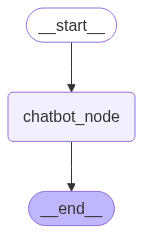

In [7]:
from langgraph.graph import StateGraph,START,END
builder = StateGraph(State)
builder.add_node("chatbot_node",chatbot_node)
builder.add_edge(START,"chatbot_node")
builder.add_edge("chatbot_node",END)
graph = builder.compile()
graph

In [8]:
responses=graph.invoke({"messages":"What is factorial of 5"})
for response in responses['messages']:
    response.pretty_print()

================================ Human Message =================================

What is factorial of 5
================================== Ai Message ==================================
Tool Calls:
  factorial (n0f4gs7jg)
 Call ID: n0f4gs7jg
  Args:
    n: 5


In [9]:
responses

{'messages': [HumanMessage(content='What is factorial of 5', additional_kwargs={}, response_metadata={}, id='75d5bdf9-5c60-46a1-9689-1dca782cd885'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n0f4gs7jg', 'function': {'arguments': '{"n":5}', 'name': 'factorial'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 206, 'prompt_tokens': 143, 'total_tokens': 349, 'completion_time': 0.487389301, 'prompt_time': 0.035179403, 'queue_time': 0.751865744, 'total_time': 0.522568704}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_18a313a21d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--439c3fa9-578b-4017-ae4c-e81950db4731-0', tool_calls=[{'name': 'factorial', 'args': {'n': 5}, 'id': 'n0f4gs7jg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 143, 'output_tokens': 206, 'total_tokens': 349})]}

### Invoking the tool

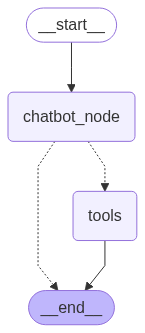

In [10]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)
builder.add_node("chatbot_node",chatbot_node)

builder.add_node("tools",ToolNode([factorial]))

builder.add_edge(START,"chatbot_node")
builder.add_edge("chatbot_node",END)

builder.add_conditional_edges("chatbot_node",tools_condition)
builder.add_edge("tools",END)


# builder.add
graph = builder.compile()
graph

In [11]:
responses=graph.invoke({"messages":"What is factorial of 5"})
for response in responses['messages']:
    response.pretty_print()

================================ Human Message =================================

What is factorial of 5
================================== Ai Message ==================================
Tool Calls:
  factorial (cxj0tntmq)
 Call ID: cxj0tntmq
  Args:
    n: 5
================================= Tool Message =================================
Name: factorial

120


In [12]:
responses=graph.invoke({"messages":"What is Machine learning?"})
for response in responses['messages']:
    response.pretty_print()

================================ Human Message =================================

What is Machine learning?
================================== Ai Message ==================================

Machine learning is a branch of artificial intelligence (AI) that focuses on developing algorithms and statistical models. These models enable computers to improve their performance at specific tasks by learning from data, rather than relying solely on explicit programming. Instead of being manually coded with rules, machine learning systems identify patterns in data to make predictions, classifications, or decisions.

**Key aspects:**
- **Training Data:** Models learn from historical data (e.g., images, text, or sensor readings).
- **Types of Learning:**
  - *Supervised learning:* Uses labeled data (e.g., predicting house prices).
  - *Unsupervised learning:* Finds hidden patterns in unlabeled data (e.g., customer segmentation).
  - *Reinforcement learning:* Learns by trial-and-error through reward